# CNN Model for Drawings recognition

Author : Hugo Mallet - 2020

This notebook aims to build a **Convolutional Neural Network** model to perform a **Multiclass classification** of drawings from the **"Quick, Draw!"** dataset, publicly available [here](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap/?pli=1).
This simple model is part of a tutorial that shows how to build an **image recognition web-app** using **Flask**.
Images are already preprocessed to 28x28 pixel image size, and sorted by category. In this tutorial, we will deal with animal drawings.

In [18]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

AttributeError: module 'keras.backend' has no attribute 'set_image_dim_ordering'

## Preprocessing

Let's load data from 6 different classes : cat, sheep, giraffe, bat, octopus and camel. Each drawing consists in 784 pixels, and each dataset has between 123 000 and 150 000 drawings.

In [19]:
# load the data
cat = np.load('data/The_Eiffel_Tower.npy')
sheep = np.load('data/ant.npy')
giraffe = np.load('data/basketball.npy')
bat = np.load('data/book.npy')
octopus = np.load('data/bracelet.npy')
camel = np.load('data/bucket.npy')

print(cat.shape)
print(sheep.shape)
print(giraffe.shape)
print(bat.shape)
print(octopus.shape)
print(camel.shape)

(134801, 784)
(124612, 784)
(133793, 784)
(119364, 784)
(119416, 784)
(124064, 784)


For each class, we add a column to set the labels. **{ 0:'cat', 1:'giraffe', 2:'sheep', 3:'bat', 4:'octopus', 5:'camel'}**


In [20]:
cat = np.c_[cat, np.zeros(len(cat))]
giraffe = np.c_[giraffe, np.ones(len(giraffe))]
sheep = np.c_[sheep, 2*np.ones(len(sheep))]
bat = np.c_[bat, 3*np.ones(len(bat))]
octopus = np.c_[octopus, 4*np.ones(len(octopus))]
camel = np.c_[camel, 5*np.ones(len(camel))]
print(cat.shape)

(134801, 785)


Let's have a look at our samples. 

In [21]:
def plot_samples(input_array, rows=4, cols=5, title=''):
    '''
    Function to plot 28x28 pixel drawings that are stored in a numpy array.
    Specify how many rows and cols of pictures to display (default 4x5).  
    If the array contains less images than subplots selected, surplus subplots remain empty.
    '''
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

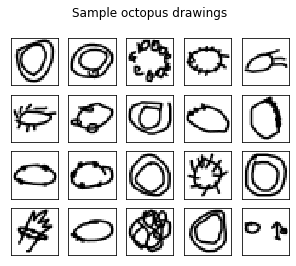

In [22]:
plot_samples(octopus, title='Sample octopus drawings\n')

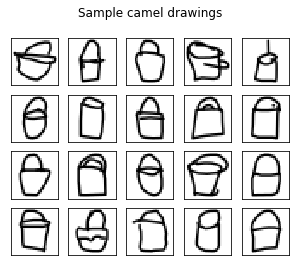

In [23]:
plot_samples(camel, title='Sample camel drawings\n')

Next step : 
* We need to combine our data so we can use it for the train and test. I will only use 10 000 samples for this model.
* We then can split the features and labels (X and y).
* Finally, we split data between train and test following the usual (80 - 20) ratio. We also normalize values between 0 and 1 (X/255) as pixels values are initially gray scale between 0 and 255.

In [24]:
# Merging arrays and splitting the features and labels
X = np.concatenate((cat[:10000,:-1], giraffe[:10000,:-1], sheep[:10000,:-1], bat[:10000,:-1], octopus[:10000,:-1], camel[:10000, :-1]), axis=0).astype('float32') # all columns but the last
y = np.concatenate((cat[:10000,-1], giraffe[:10000,-1], sheep[:10000,-1], bat[:10000,-1], octopus[:10000,-1],  camel[:10000,-1]), axis=0).astype('float32') # the last column

# We than split data between train and test (80 - 20 usual ratio). Normalizing the value between 0 and 1
X_train, X_test, y_train, y_test = train_test_split(X/255.,y,test_size=0.2,random_state=0)

Output variable is an integer from 0 to 5 (MultiClass Classification problem). We are gonna use a one hot encoding of the class values.

In [25]:
# one hot encode outputs
y_train_cnn = np_utils.to_categorical(y_train)
y_test_cnn = np_utils.to_categorical(y_test)
num_classes = y_test_cnn.shape[1]

In [26]:
# reshape to be [samples][pixels][width][height]
X_train_cnn = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

# CNN Model

We will now to build our CNN model using Keras. This model will have the following layers : 
   * **Convolutional Layer** : 30 filters, (3 * 3) kernel  size
   * **Max Pooling Layer** : (2 * 2) pool size
   * **Convolutional Layer** : 15 filters, (3 * 3) kernel size
   * **Max Pooling Layer** : (2 * 2) pool size
   * **DropOut Layer** : Dropping 20% of neurons.
   * **Flatten Layer**
   * **Dense/Fully Connected Layer** : 128 Neurons, *Relu* activation function
   * **Dense/Fully Connected Layer** : 50 Neurons, *Softmax* activation function
   
**Input shape** : pixels * width * height : 1 * 28 * 28

We run our model for **15** epochs and with a batch size of **200**.

In [33]:
def cnn_model():
    # create model
    model = Sequential()
    #model.add(Conv2D(30, (3, 3), input_shape=(1, 28, 28), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Conv2D(15, (3, 3), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [34]:
%%time
np.random.seed(0)
# build the model
model_cnn = cnn_model()
# Fit the model
model_cnn.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn), epochs=15, batch_size=200)
# Final evaluation of the model
scores = model_cnn.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Final CNN accuracy: ', scores[1])

Epoch 1/15
240/240 [==============================] - 1s 2ms/step - loss: 0.5426 - accuracy: 0.8315 - val_loss: 0.3884 - val_accuracy: 0.8802
Epoch 2/15
240/240 [==============================] - 0s 2ms/step - loss: 0.3612 - accuracy: 0.8877 - val_loss: 0.3351 - val_accuracy: 0.8972
Epoch 3/15
240/240 [==============================] - 0s 2ms/step - loss: 0.3141 - accuracy: 0.9013 - val_loss: 0.3038 - val_accuracy: 0.9076
Epoch 4/15
240/240 [==============================] - 0s 2ms/step - loss: 0.2857 - accuracy: 0.9097 - val_loss: 0.2888 - val_accuracy: 0.9124
Epoch 5/15
240/240 [==============================] - 0s 2ms/step - loss: 0.2607 - accuracy: 0.9174 - val_loss: 0.2792 - val_accuracy: 0.9155
Epoch 6/15
240/240 [==============================] - 0s 2ms/step - loss: 0.2398 - accuracy: 0.9242 - val_loss: 0.2831 - val_accuracy: 0.9136
Epoch 7/15
240/240 [==============================] - 0s 2ms/step - loss: 0.2262 - accuracy: 0.9282 - val_loss: 0.2684 - val_accuracy: 0.9166
Epoch 

After our 15 epochs, we finally almost reach **93** % accuracy which seems fair for our project and with only a small part of the total dataset used for training! Let's go further and analyse the confusion matrix.

# Confusion Matrix

In [36]:
y_pred_cnn = np.argmax(model_cnn.predict(X_test_cnn, verbose=0),axis=1)

In [37]:
from sklearn import metrics
c_matrix = metrics.confusion_matrix(y_test, y_pred_cnn)

In [38]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


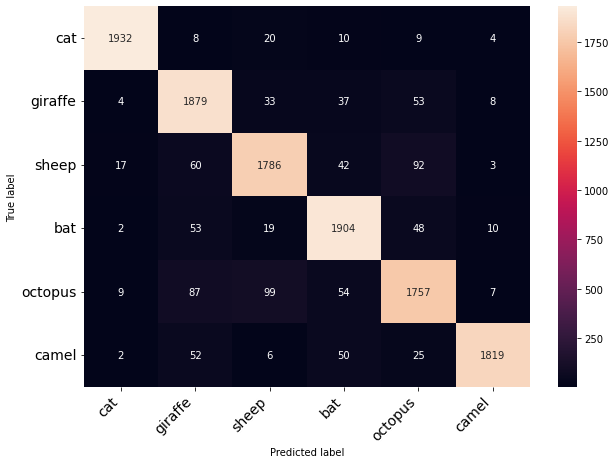

In [39]:
class_names = ['cat', 'giraffe', 'sheep', 'bat', 'octopus', 'camel']
confusion_matrix(c_matrix, class_names, figsize = (10,7), fontsize=14)

In [40]:
#Misclassification when y_pred and y_test are different.
misclassified = X_test[y_pred_cnn != y_test]

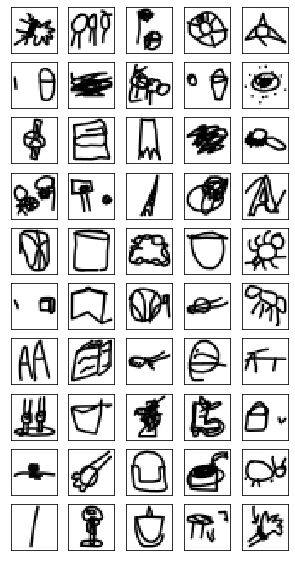

In [41]:
plot_samples(misclassified, rows=10, cols=5, title='')

Those results seems good : most of the misclassified images could have been easily mistaken, even by an human.

## Saving our model

As stated earlier, we would like to embbed our model in **Flask Web-App**. To do so, it is more convenient to save (serialize) our model using **pickle**.
*(Note : You could directly train your model into flask, but it would be really time consuming and inefficient).*
By doing so, we will be able to predict new images given by the user.

In [42]:
import pickle
with open('model_cnn.pkl', 'wb') as file:
      pickle.dump(model_cnn, file)

2021-11-29 12:39:24.166130: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://8bca7cfb-d3a3-4b1f-8b69-8b03e143a046/assets


That's it ! We will now use our model_cnn to predict new user inputs by embedding it into a flask app !